# Elevated-Plus Maze Analysis

In [1]:
from analysis import analysis_utils as au
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Process
from multiprocessing import Queue
import numpy as np
import os
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import SigProc
import sys

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"
sns.set_style("darkgrid")

## Organize all the files for each mouse. Go through the EPM directory, and for each mouse, add the corresponding behavior data file path name and the corresponding Raw data file path name to a dictionary.

In [3]:
mouse_directory = os.path.expanduser("~") + "/Hen_Lab/Mice/EPM"

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

animal_data = dict()
print("Files found:")
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    if subdir_list:
        mice_directories = subdir_list

    for file_name in file_list:
        for mouse_name in mice_directories:
            if file_name.endswith(".csv") and (mouse_name in file_name and "behavior" in file_name):
                if mouse_name in animal_data:
                    animal_data[mouse_name].update({"behavior":dir_name+"/"+file_name})
                else:
                    animal_data[mouse_name] = {"behavior":dir_name+"/"+file_name}
                # print(dir_name+"/"+file_name)
            elif file_name.endswith(".csv") and (mouse_name in file_name and "Raw" in file_name):
                if mouse_name in animal_data:
                    animal_data[mouse_name].update({"Raw":dir_name+"/"+file_name})
                else:
                    animal_data[mouse_name] = {"Raw":dir_name+"/"+file_name}
                # print(dir_name+"/"+file_name)

Files found:


In [4]:
animal_data

{'drd87': {'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv',
  'Raw': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv'},
 'drd73': {'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv'},
 'drd77': {'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/behavior_drd77.csv'},
 'drd46': {'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv',
  'Raw': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv'}}

## If a behavior data file or a Raw data file is missing for a particular mouse, then display which file is missing. Then proceed to remove all mice from the dictionary that do not have the required data files, i.e., behavior and raw.

In [5]:
# Check that for each animal a corresponding behavior data file AND Raw neuron data file was found
missing_data = list()
for mouse_name in animal_data:
    if not "behavior" in animal_data[mouse_name]:
        print("The behavior for {} file is missing".format(mouse_name))
        missing_data.append(mouse_name)
    if not "Raw" in animal_data[mouse_name]:
        print("The raw file for {} is missing".format(mouse_name))
        missing_data.append(mouse_name)
    
# Remove all mice from the dictionary if the required data files for them were not found
for animal_name in missing_data:
    if animal_name in animal_data:
        del animal_data[animal_name]

The raw file for drd73 is missing
The raw file for drd77 is missing


In [6]:
animal_data

{'drd87': {'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv',
  'Raw': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv'},
 'drd46': {'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv',
  'Raw': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv'}}

drd87
drd46


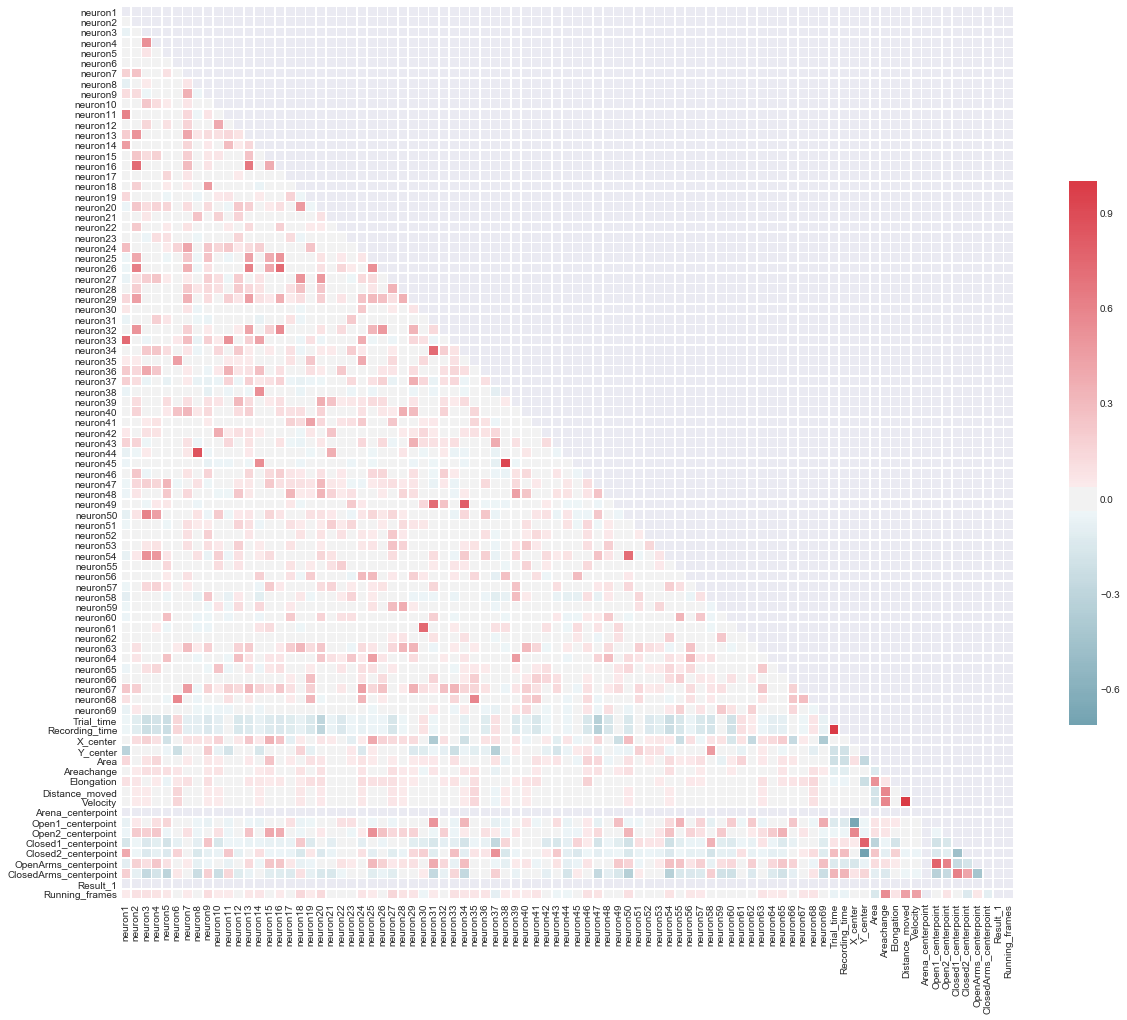

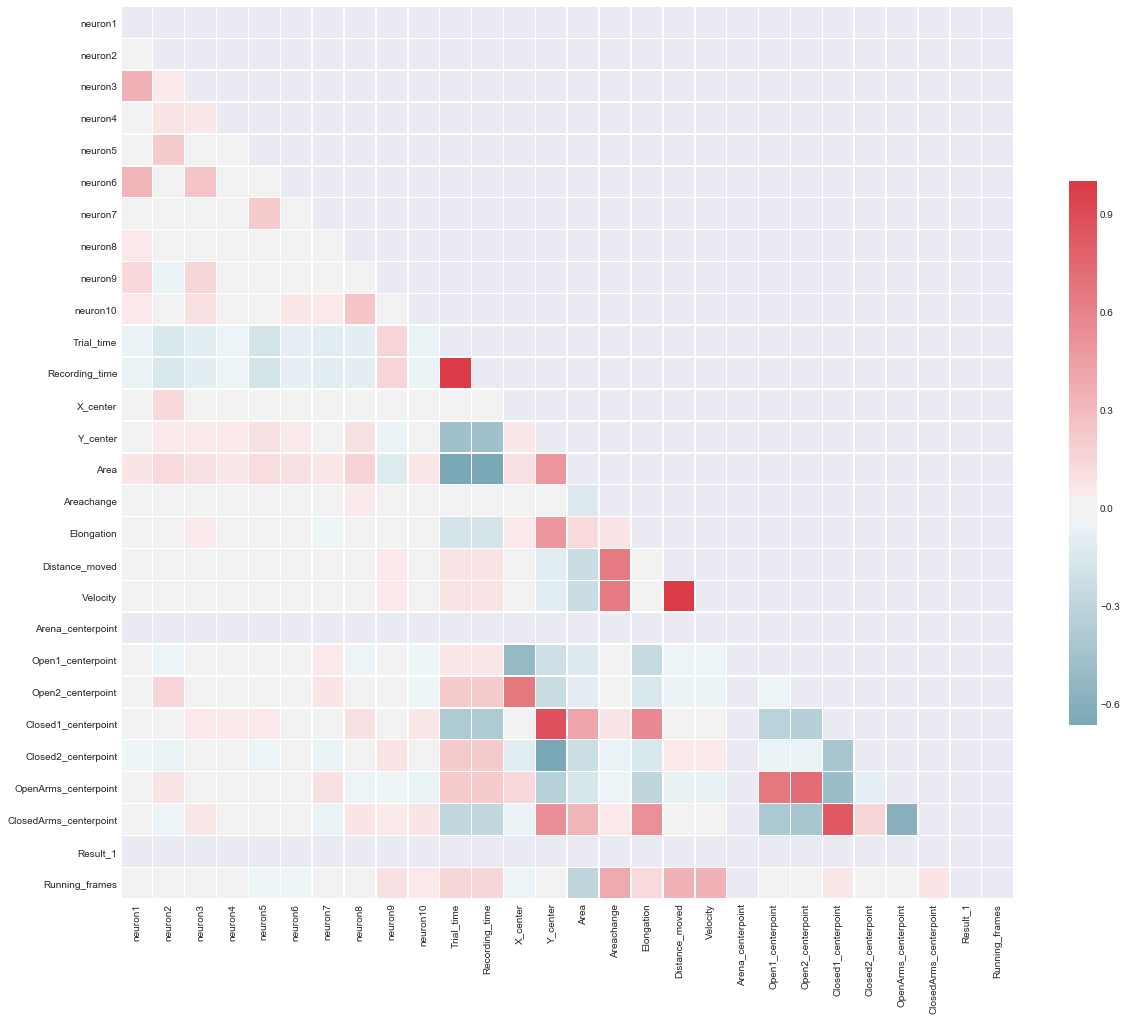

In [7]:
for animal_name in animal_data:
    print(animal_name)
    
    data = pd.read_csv(animal_data[animal_name]["Raw"], header=None)
    _, AUC_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)
    
    behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

    behavior_df = pd.read_csv(animal_data[animal_name]["behavior"], header=None)
    behavior_df.columns = behavior_column_names
    
    # Only keep every 3rd row of the original behavior dataframe in order to downsample 30 fps --> 10 fps
    behavior_df = au.downsample_dataframe(behavior_df, 3)

    # Define cutoff for what constitutes as a running frame
    VELOCITY_CUTOFF = 4;

    # Adds "Running_frames" column to the end of the behavior dataframe 
    behavior_df["Running_frames"] = np.where(behavior_df["Velocity"] > VELOCITY_CUTOFF, 1, 0)
    
    neuron_concated_behavior = cell_transients_dataframe.join(behavior_df, how="left")
    
    au.plot_correlation_heatmap(neuron_concated_behavior, size=20)

In [8]:
data = pd.read_csv(animal_data["drd87"]["Raw"], header=None)
_, AUC_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                     'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                     'Open1_centerpoint', 'Open2_centerpoint',
                     'Closed1_centerpoint', 'Closed2_centerpoint',
                     'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

behavior_df = pd.read_csv(animal_data["drd87"]["behavior"], header=None)
behavior_df.columns = behavior_column_names

# Only keep every 3rd row of the original behavior dataframe in order to downsample 30 fps --> 10 fps
behavior_df = au.downsample_dataframe(behavior_df, 3)

# Define cutoff for what constitutes as a running frame
VELOCITY_CUTOFF = 4;

# Adds "Running_frames" column to the end of the behavior dataframe 
behavior_df["Running_frames"] = np.where(behavior_df["Velocity"] > VELOCITY_CUTOFF, 1, 0)

neuron_concated_behavior = cell_transients_dataframe.join(behavior_df, how="left")

Arena_centerpoint
Open1_centerpoint
Open2_centerpoint
Closed1_centerpoint
Closed2_centerpoint
OpenArms_centerpoint
ClosedArms_centerpoint


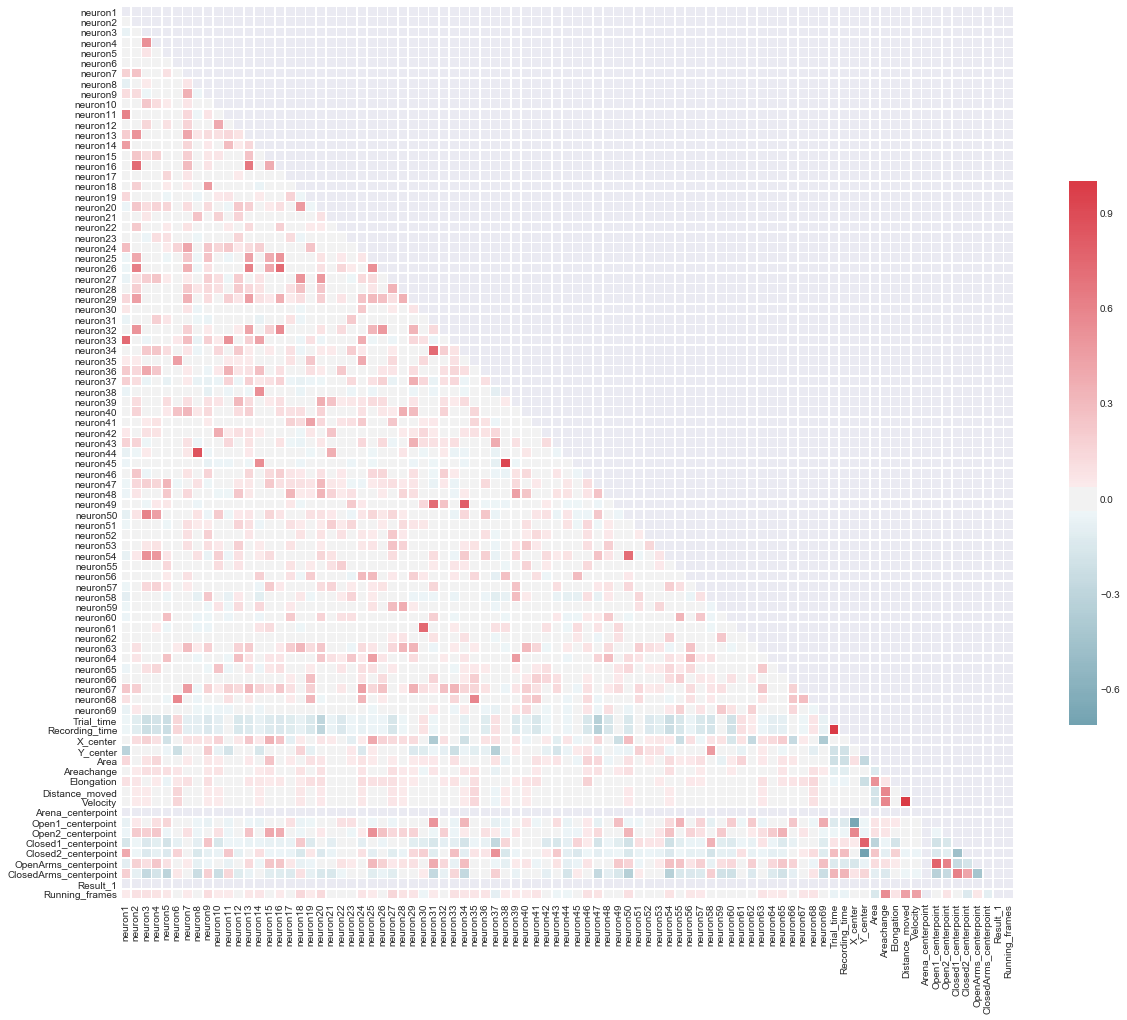

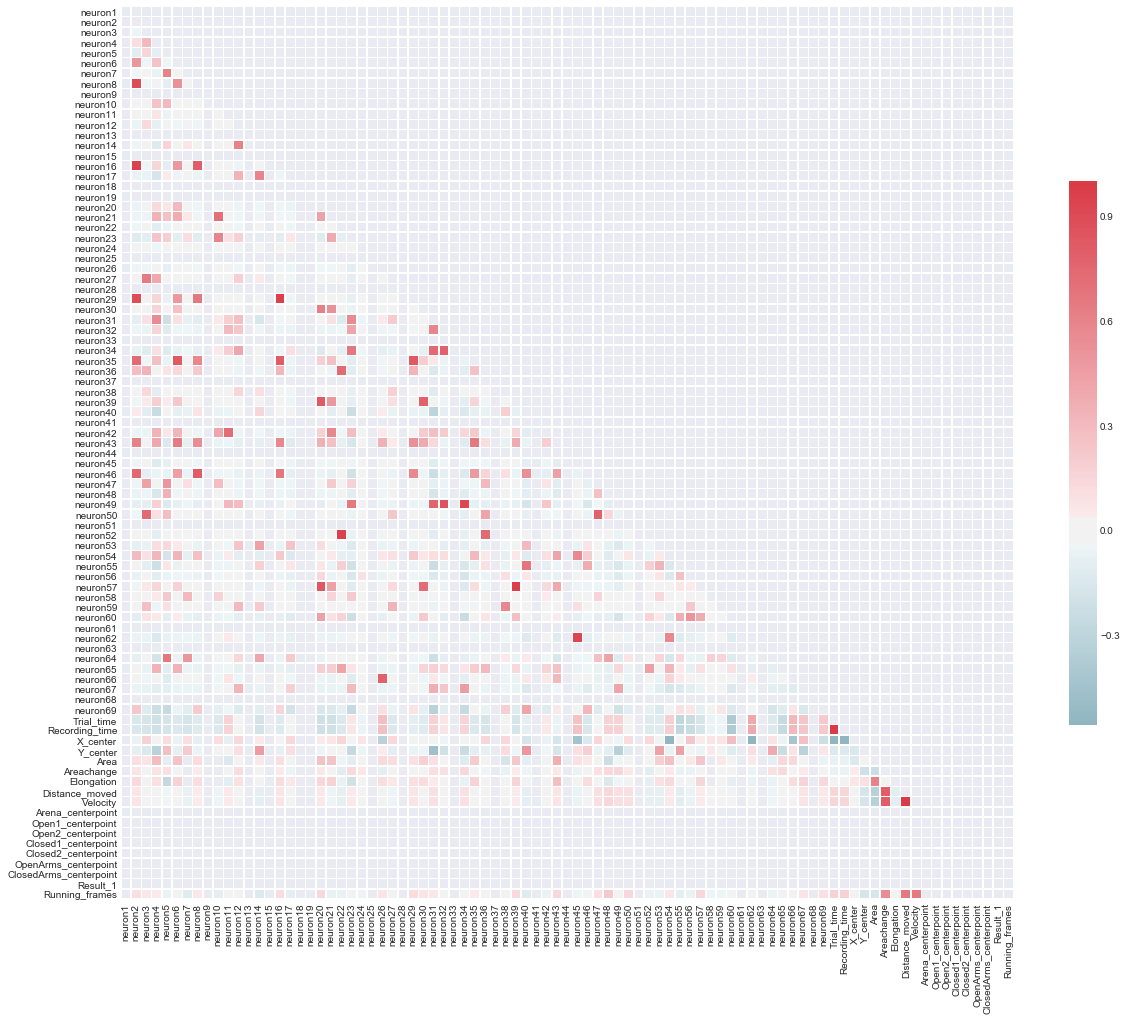

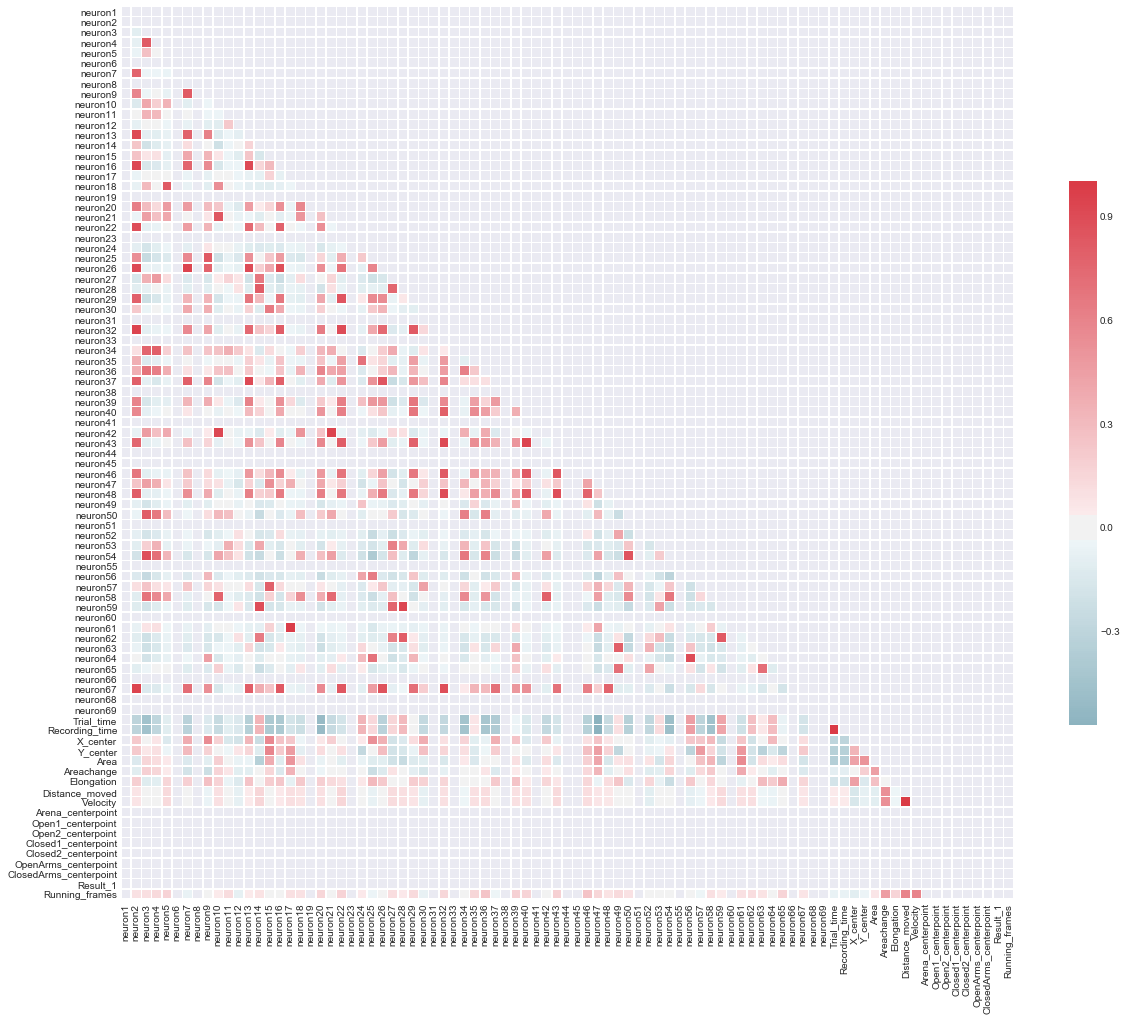

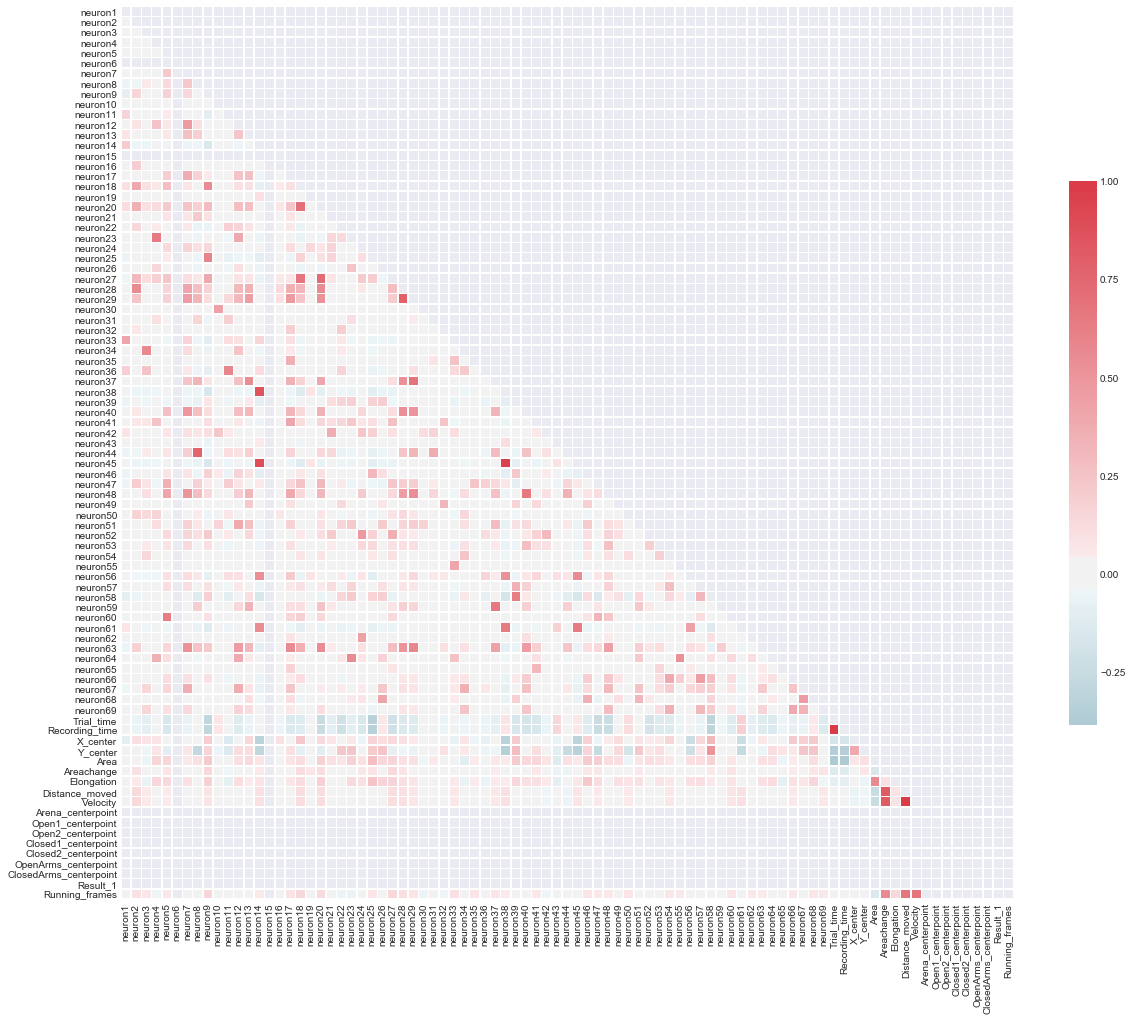

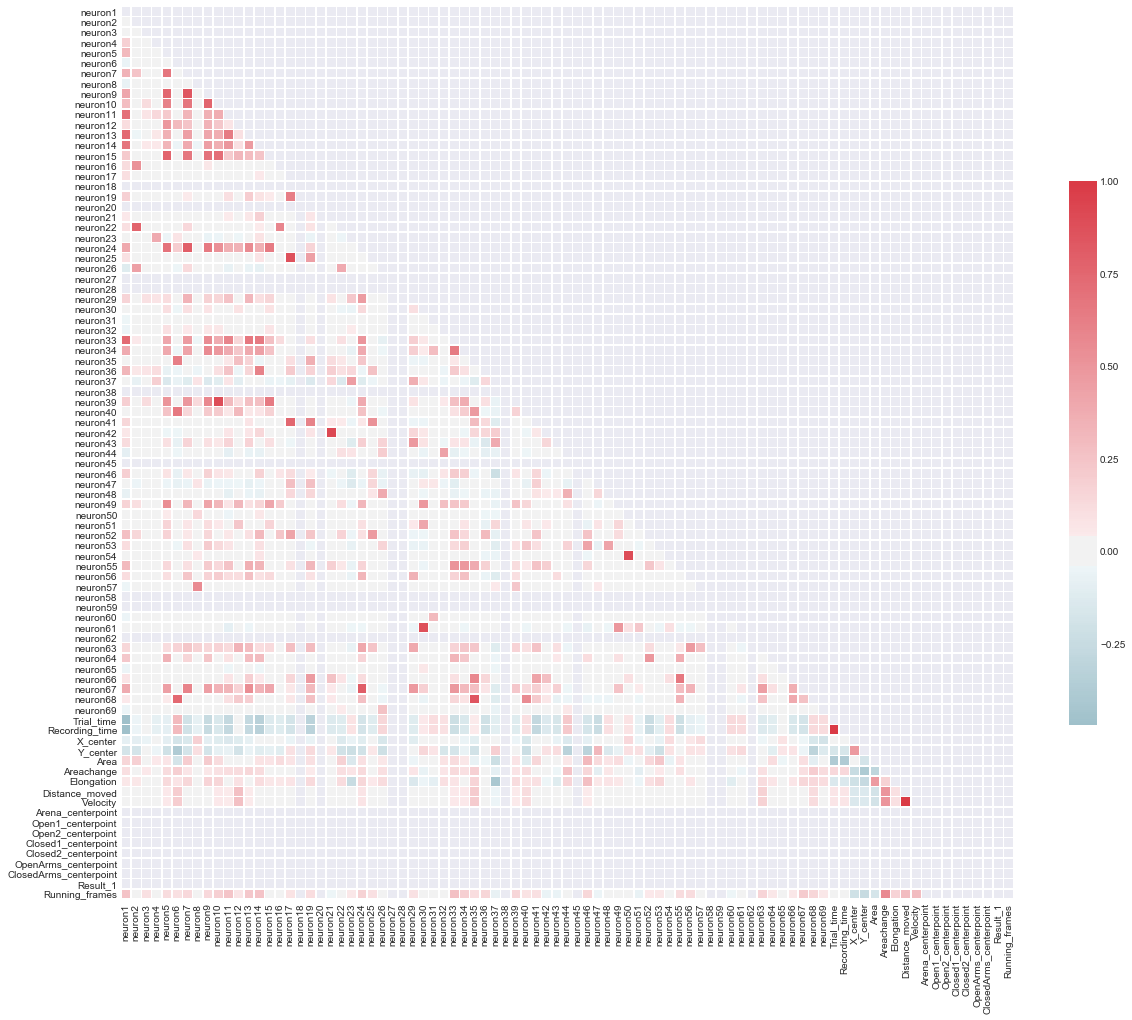

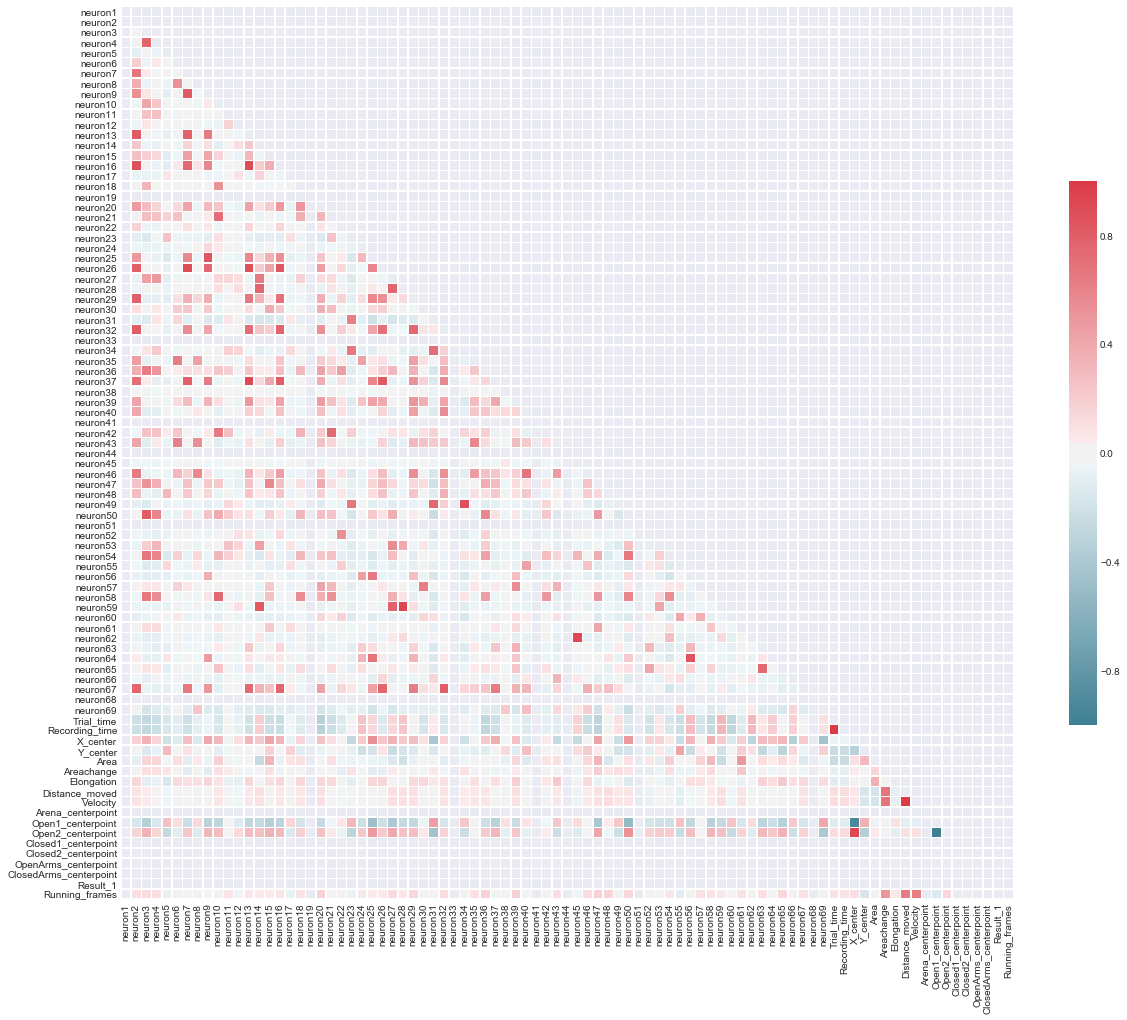

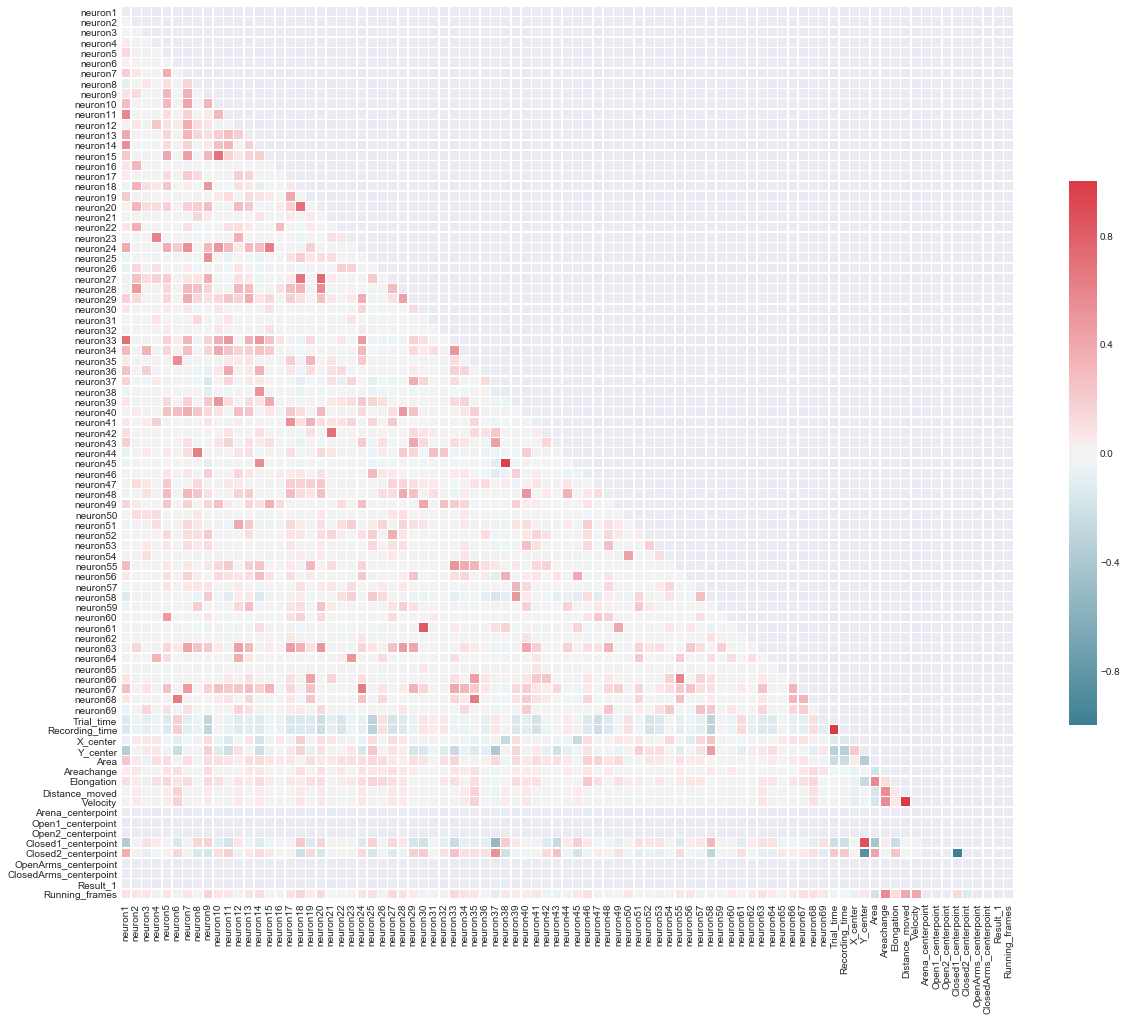

In [9]:
behaviors = ["Arena_centerpoint", "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint"]
for behavior in behaviors:
    print(behavior)
    au.plot_correlation_heatmap(neuron_concated_behavior.loc[neuron_concated_behavior[behavior] != 0], size=20)